# Celebrity Look a Like CNN DL Project

#### Mohamed Youssef - 211001821


## Index


-   [Including Necessary Libraries](#libs)
    <br>
-   [Other Utilites](#uti)
    <br>
-   [Loading & Cleaning the Data](#dataset)
    - [Reading Meta Data](#metadata)
    - [Creating Data Frame](#dataframe)
    - [Data Cleaning](#clean)
    <br>
-   [Visualization](#vis)
    -   [Univariate Exploration](#univis)
    -   [Bivariate Exploration](#bivis)
    <br>
-   [Preprocessing Data](#pre)
    -   [Getting Image Pixels](#pix)
    -   [Normalizing the Images](#norm)
-   [Neural Network Construction](#cnn)
    -   [Building the Network (Vgg Face Descriptor Model)](#bld)
    -   [Importing Weights](#wghts)
    -   [Predicting Face Vector Representaion](#vct)

In [1]:
# Disable warnings (comment this to turn on warnings)
import warnings


def warn(*args, **kwargs):
    pass


warnings.warn = warn

## Including Necessary Librariess<a id='libs'></a>


In [2]:
# Importing necessary libraries

from datetime import datetime, timedelta  # For dealing with celebrity ages
import time  # For measuring time taken to run specific cells
import glob  # For getting test image paths

import chime  # For making a sound when there is an error

import scipy.io  # For loading .mat files
import numpy as np  # For dealing with arrays and matrices
import pandas as pd  # For dealing with dataframes

import matplotlib.pyplot as plt  # For plotting images and graphs
import matplotlib.patches as mpatches  # For drawing shapes in the legend
from keras.utils.vis_utils import plot_model  # For plotting the model

import cv2  # For image processing
import keras.preprocessing.image as image  # For turning images into arrays

# For building the CNN model
from keras.models import Sequential
from keras.layers import (
    Dropout,
    Flatten,
    Convolution2D,
    ZeroPadding2D,
    MaxPooling2D,
)

import tensorflow as tf  # For configuring the GPU

## Other Utilites<a id='uti'></a>


In [3]:
# Setting the path to the current directory
dataset_path = "C:/Data Sets/CLA Dataset"
print("Dataset path is: " + dataset_path)

Dataset path is: C:/Data Sets/CLA Dataset


In [4]:
# Configuring the GPU for training the model

gpus = tf.config.list_physical_devices("GPU")  # Getting the list of GPUs available

# If there is a GPU available, then set the GPU to be used for training the model
if gpus:
    print("GPUs Available: ", gpus)

    # If there are two GPUs available, then use the second GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], "GPU")
        tf.config.experimental.set_memory_growth(gpus[1], True)

    # If there is only one GPU available, then use the first GPU
    except:
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        tf.config.experimental.set_memory_growth(gpus[0], True)

# If there is no GPU available, then use the CPU
else:
    print("No GPU Available")

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# Initializing chime
chime.theme("mario")
chime.notify_exceptions()

In [6]:
# Set to True if you want to download the dataset
download_dataset = False

In [7]:
# Downloading the imdb_crop dataset from the link into the current/Data directory
if download_dataset == False:
    print("Dataset not downloaded. Please download the dataset, if you already have the dataset ignore this message.")
else:
    !wget -P "{dataset_path}" https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar

Dataset not downloaded. Please download the dataset, if you already have the dataset ignore this message.


In [8]:
# Extracting the dataset from the tar file
if download_dataset == False:
    print("Dataset not extracted. Please extract the dataset, if you already have the dataset extracted ignore this message.")
else:
    !tar -xvf "{dataset_path}"/imdb_crop.tar -C "{dataset_path}"/imdb_crop

Dataset not extracted. Please extract the dataset, if you already have the dataset extracted ignore this message.


## Loading & Cleaning the Data <a id='dataset'></a>


### Reading Meta Data <a id='metadata'></a>


In [9]:
# Loading the mat file containing the data
data_mat = scipy.io.loadmat(dataset_path + "/imdb_crop/imdb_crop/imdb.mat")

In [10]:
# Getting the total number of records in the data
records_len = data_mat["imdb"][0][0][0].shape[1]
print("Total no. of records:", records_len)

Total no. of records: 460723


In [11]:
# Getting the column names of the data
features = data_mat["imdb"][0][0].dtype
features = list(features.names)
features_len = len(features)
print("Total no. of features:", features_len)

Total no. of features: 10


In [12]:
# Renaming the features for better readability
print("Current Features Names:\n", features)
features[0] = "Date of Birth"
features[1] = "Photo Taken Date"
features[2] = "Full Img Path"
features[3] = "Gender"
features[4] = "Celebrity Name"
features[5] = "Face Location"
features[6] = "Face Score"
features[7] = "Second Face Score"
features[8] = "Celeb Names"
features[9] = "Celeb ID"
print("New Features Names:\n", features)

Current Features Names:
 ['dob', 'photo_taken', 'full_path', 'gender', 'name', 'face_location', 'face_score', 'second_face_score', 'celeb_names', 'celeb_id']
New Features Names:
 ['Date of Birth', 'Photo Taken Date', 'Full Img Path', 'Gender', 'Celebrity Name', 'Face Location', 'Face Score', 'Second Face Score', 'Celeb Names', 'Celeb ID']


### Creating Data Frame <a id='dataframe'></a>


In [13]:
# Creating a dataframe to store the data
data_df = pd.DataFrame(index=(range(0, records_len)), columns=features)

In [14]:
# Extracting the data from the mat file and storing it in a dataframe
for i in data_mat:
    if i == "imdb":
        current_array = data_mat[i][0][0]
        for j in range(len(current_array)):
            data_df[features[j]] = pd.DataFrame(current_array[j][0])

In [15]:
# Displaying 5 random rows of the data
data_df.sample(5)

Date of Birth  Photo Taken Date  \
330801         726415              2008   
104097         711528              1984   
698            697383              1983   
339562         719925              2011   
385508         717016              1997   

                                         Full Img Path  Gender  \
330801  [26/nm2057726_rm2449639936_1988-11-8_2008.jpg]     0.0   
104097   [02/nm0001302_rm2353183488_1948-2-5_1984.jpg]     1.0   
698     [51/nm0000051_rm1579531008_1909-5-15_1983.jpg]     1.0   
339562   [10/nm0355910_rm1430041344_1971-2-1_2011.jpg]     1.0   
385508  [86/nm0170186_rm1466616064_1963-2-14_1997.jpg]     1.0   

             Celebrity Name  \
330801    [Jessica Lowndes]   
104097  [Christopher Guest]   
698           [James Mason]   
339562    [Michael C. Hall]   
385508   [Enrico Colantoni]   

                                            Face Location  Face Score  \
330801  [[111.64875021349623, 93.1512918445802, 277.46...    4.036148   
104097  [[627.3564590223913, 33.4195582252961, 723.523...    1.783928   
698     [[200.51140268043338, 243.25891754052626, 327....    1.915249   
339562  [[1276.4241253256432, 233.75275005920787, 1482...    2.745024   
385508                             [[675, 387, 888, 600]]    2.910746   

        Second Face Score         Celeb Names  Celeb ID  
330801                NaN                 NaN      9063  
104097           1.780505                 NaN      3671  
698                   NaN  [Allison Williams]      8265  
339562           0.867949                 NaN     13495  
385508           1.518288                 NaN      5925

In [16]:
# Describing the data
data_df.describe()

Date of Birth  Photo Taken Date         Gender    Face Score  \
count  460723.000000     460723.000000  452261.000000  4.607230e+05   
mean   718987.731774       2005.461555       0.581996          -inf   
std     13253.963535          9.054475       0.493231           NaN   
min        47.000000       1961.000000       0.000000          -inf   
25%    716370.000000       2004.000000       0.000000  1.757891e+00   
50%    719935.000000       2008.000000       1.000000  2.980097e+00   
75%    723073.000000       2011.000000       1.000000  4.006376e+00   
max    734963.000000       2015.000000       1.000000  7.381689e+00   

       Second Face Score       Celeb ID  
count      213797.000000  460723.000000  
mean            2.452904   10116.802404  
std             1.064432    5742.153266  
min             0.730926       1.000000  
25%             1.583692    5294.000000  
50%             2.355163   10066.000000  
75%             3.228071   14922.000000  
max             6.395435   20284.000000

In [17]:
# Checking for null values in the data
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460723 entries, 0 to 460722
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date of Birth      460723 non-null  int32  
 1   Photo Taken Date   460723 non-null  uint16 
 2   Full Img Path      460723 non-null  object 
 3   Gender             452261 non-null  float64
 4   Celebrity Name     460723 non-null  object 
 5   Face Location      460723 non-null  object 
 6   Face Score         460723 non-null  float64
 7   Second Face Score  213797 non-null  float64
 8   Celeb Names        20284 non-null   object 
 9   Celeb ID           460723 non-null  uint16 
dtypes: float64(3), int32(1), object(4), uint16(2)
memory usage: 28.1+ MB


### Data Cleaning <a id='clean'></a>


In [18]:
# Removing pictures with no face detected
data_df = data_df[data_df["Face Score"] != -np.inf]
print("Total no. of records with no face detected removed:", records_len - len(data_df))
records_len = len(data_df)  # Updating the total number of records
print("Total no. of records after removing records with no face detected:", records_len)

Total no. of records with no face detected removed: 62302
Total no. of records after removing records with no face detected: 398421


In [19]:
# Removing pictures with more than one face detected
data_df = data_df[data_df["Second Face Score"].isna()]
print(
    "Total no. of records with more than one face detected removed:",
    records_len - len(data_df),
)
records_len = len(data_df)  # Updating the total number of records
print(
    "Total no. of records after removing pictures with more the one face:", records_len
)

Total no. of records with more than one face detected removed: 213797
Total no. of records after removing pictures with more the one face: 184624


In [20]:
def extract_data(arr):
    """
    Extracts the first element from the given array.

    Parameters:
    -   arr (list or array-like): The array from which to extract the first element.

    Returns:
    -   element: The first element of the input array.
    """
    return arr[0]

In [21]:
# Extracting the data from the array columns of the dataframe
data_df["Celebrity Name"] = data_df["Celebrity Name"].apply(extract_data)
data_df["Full Img Path"] = data_df["Full Img Path"].apply(extract_data)

In [22]:
# Dropping the unnecessary columns from the dataframe
data_df.drop(
    ["Celeb ID", "Celeb Names", "Second Face Score", "Face Location"],
    axis=1,
    inplace=True,
)

In [23]:
# Getting the number of features in the data after dropping unnecessary columns
features_len = len(data_df.columns)
print("Total no. of features after dropping unnecessary columns:", features_len)

Total no. of features after dropping unnecessary columns: 6


In [24]:
# Displaying the first row of the data after dropping unnecessary columns
data_df.head(1)

Date of Birth  Photo Taken Date  \
3         693726              1968   

                                 Full Img Path  Gender Celebrity Name  \
3  01/nm0000001_rm946909184_1899-5-10_1968.jpg     1.0   Fred Astaire   

   Face Score  
3    1.872117

In [25]:
def convert_date(date_number):
    """
    Converts a MATLAB serial date number to a Python datetime object.

    Parameters:
    -   date_number (int or float): The MATLAB serial date number to convert.

    Returns:
    -   datetime or str: The converted date as a datetime object or a string in the format YYYY.
    -   If an OverflowError occurs during conversion, returns pandas NaT (Not a Time) as a placeholder for missing or null date values.
    """
    str_date = str(date_number)

    # If the length of the string is 4, then the date is in the format YYYY
    if len(str_date) == 4:
        full_date = datetime.strptime(str_date, "%Y")
        return full_date.strftime("%Y")

    # If the length of the string is 7, then the date is in the format YYYY.MM
    else:
        try:
            date_time = (
                datetime.fromordinal(int(date_number))
                + timedelta(days=date_number % 1)
                - timedelta(days=366)
            )
            return date_time
        except OverflowError:
            return pd.NaT

In [26]:
# Converting the matlab serial date number to python date time object
data_df["Date of Birth"] = data_df["Date of Birth"].apply(convert_date)

In [27]:
# Converting the Photo Taken Date to python year date time object
data_df["Photo Taken Date"] = data_df["Photo Taken Date"].apply(convert_date)

In [28]:
def calculate_age_at_photo(born, photo_taken):
    """
    Calculates the age of a person at the time a photo was taken.

    Parameters:
    -   born (datetime): The birth date of the person.
    -   photo_taken (str): The year the photo was taken, in the format "YYYY".

    Returns:
    -   int or np.nan: The age of the person at the time the photo was taken. If an AttributeError occurs (e.g., if 'born' is not a datetime object), returns np.nan.
    """
    photo_taken = datetime.strptime(photo_taken, "%Y")
    try:
        return (
            photo_taken.year
            - born.year
            - ((photo_taken.month, photo_taken.day) < (born.month, born.day))
        )
    except AttributeError:
        return np.nan

In [29]:
# Calculating the age of the celebrity
data_df["Age at Photo"] = data_df.apply(
    lambda x: calculate_age_at_photo(x["Date of Birth"], x["Photo Taken Date"]), axis=1
)
# Changing the datatype of the age column to integer
data_df["Age at Photo"] = data_df["Age at Photo"].astype("Int64")

In [30]:
def calculate_current_age(born):
    """
    Calculates the current age of a person based on their birth date.

    Parameters:
    -   born (datetime): The birth date of the person.

    Returns:
    -   int or np.nan: The current age of the person. If an AttributeError occurs (e.g., if 'born' is not a datetime object), returns np.nan.
    """
    today = datetime.today()
    try:
        return (
            today.year - born.year - ((today.month, today.day) < (born.month, born.day))
        )
    except AttributeError:
        return np.nan

In [31]:
# Calculating the current age of the celebrity
data_df["Current Age"] = data_df["Date of Birth"].apply(calculate_current_age)
# Changing the datatype of the age column to integer
data_df["Current Age"] = data_df["Current Age"].astype("Int64")

In [32]:
# Dropping the Date of Birth and Photo Taken Date columns
data_df.drop(["Date of Birth", "Photo Taken Date"], axis=1, inplace=True)

In [33]:
# Getting the number of features in the data after replacing the date columns
features_len = len(data_df.columns)
print("Total no. of features after replacing the date columns:", features_len)

Total no. of features after replacing the date columns: 6


In [34]:
# Displaying the first row of the data after replacing the date columns
data_df.head(1)

Full Img Path  Gender Celebrity Name  \
3  01/nm0000001_rm946909184_1899-5-10_1968.jpg     1.0   Fred Astaire   

   Face Score  Age at Photo  Current Age  
3    1.872117            68          124

In [35]:
# Dropping any rows with null values
data_df.dropna(inplace=True)
print("Total no. of records with null values removed:", records_len - len(data_df))
records_len = len(data_df)  # Updating the total number of records
print("Total no. of records after removing null values:", len(data_df))

Total no. of records with null values removed: 2990
Total no. of records after removing null values: 181634


In [36]:
# Removing the records with age at photo less than 0
data_df = data_df[data_df["Age at Photo"] >= 0]
print("Total no. of records with -ve age removed:", records_len - len(data_df))
records_len = len(data_df)  # Updating the total number of records
print("Total no. of records after removing -ve age values:", len(data_df))

Total no. of records with -ve age removed: 154
Total no. of records after removing -ve age values: 181480


In [37]:
# Changing the datatype of the gender column to integer
data_df["Gender"] = data_df["Gender"].astype(int)

In [38]:
# Reordering the columns of the dataframe
data_df = data_df.reindex(
    columns=[
        "Celebrity Name",
        "Gender",
        "Current Age",
        "Age at Photo",
        "Full Img Path",
        "Face Score",
    ]
)

In [39]:
# Displaying the first row of the data after reordering the columns
data_df.head(1)

Celebrity Name  Gender  Current Age  Age at Photo  \
3   Fred Astaire       1          124            68   

                                 Full Img Path  Face Score  
3  01/nm0000001_rm946909184_1899-5-10_1968.jpg    1.872117

In [40]:
# Keep only unique celebrities in the data with the highest face score
data_df = data_df.sort_values(by=["Face Score"], ascending=False)
data_df.drop_duplicates(subset="Celebrity Name", keep="first", inplace=True)
print(
    "Total no. of records with duplicate celebrities removed:",
    records_len - len(data_df),
)
records_len = len(data_df)  # Updating the total number of records
print("Total no. of records after removing duplicate celebrities:", len(data_df))

Total no. of records with duplicate celebrities removed: 166870
Total no. of records after removing duplicate celebrities: 14610


In [41]:
# Filtering the data to keep only celebrities with a face score of 3 or more
data_df = data_df[data_df["Face Score"] >= 3]
print("Total no. of records with low face score removed:", records_len - len(data_df))
records_len = len(data_df)  # Updating the total number of records
print("Total no. of records after removing low face scores values:", len(data_df))

Total no. of records with low face score removed: 3193
Total no. of records after removing low face scores values: 11417


In [42]:
# Dropping the Face Score column
data_df.drop(["Face Score"], axis=1, inplace=True)

In [43]:
# Getting the number of features in the data after dropping the Face Score column
features_len = len(data_df.columns)
print("Total no. of features after dropping the Face Score column:", features_len)

Total no. of features after dropping the Face Score column: 5


In [44]:
# Resetting the index of the dataframe
data_df.reset_index(drop=True, inplace=True)

In [45]:
# Displaying 5 random rows of the data
data_df.sample(5)

Celebrity Name  Gender  Current Age  Age at Photo  \
9135    Herbie Hancock       1           83            74   
1034   McCaleb Burnett       1           46            28   
11337      Sammy Sheik       1           42            25   
7781    Joshua Leonard       1           48            38   
4966      J.K. Simmons       1           68            48   

                                       Full Img Path  
9135    72/nm0359372_rm2753166592_1940-4-12_2015.jpg  
1034    31/nm1080831_rm1823316736_1977-11-0_2006.jpg  
11337  33/nm1879133_rm1152243712_1981-11-15_2007.jpg  
7781    71/nm0502671_rm4062756864_1975-6-17_2014.jpg  
4966     77/nm0799777_rm2745276416_1955-1-9_2004.jpg

In [46]:
# Describing the data
data_df.describe()

Gender   Current Age  Age at Photo
count  11417.000000  11417.000000  11417.000000
mean       0.572304     55.431462     35.960760
std        0.494766     17.635040     14.467294
min        0.000000     16.000000      0.000000
25%        0.000000     43.000000     26.000000
50%        1.000000     52.000000     34.000000
75%        1.000000     65.000000     44.000000
max        1.000000    147.000000    133.000000

In [47]:
# Checking for null values in the data
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11417 entries, 0 to 11416
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Celebrity Name  11417 non-null  object
 1   Gender          11417 non-null  int32 
 2   Current Age     11417 non-null  Int64 
 3   Age at Photo    11417 non-null  Int64 
 4   Full Img Path   11417 non-null  object
dtypes: Int64(2), int32(1), object(2)
memory usage: 423.8+ KB


In [48]:
# Getting the number of features in the data after cleaning
features_len = len(data_df.columns)
print("Total no. of features after cleaning:", features_len)

Total no. of features after cleaning: 5


In [49]:
# Getting the total number of records in the data after cleaning
records_len = len(data_df)
print("Total no. of records after cleaning:", records_len)

Total no. of records after cleaning: 11417


## Visualization <a id="vis"></a>


### Univariate Exploration <a id="univis"></a>


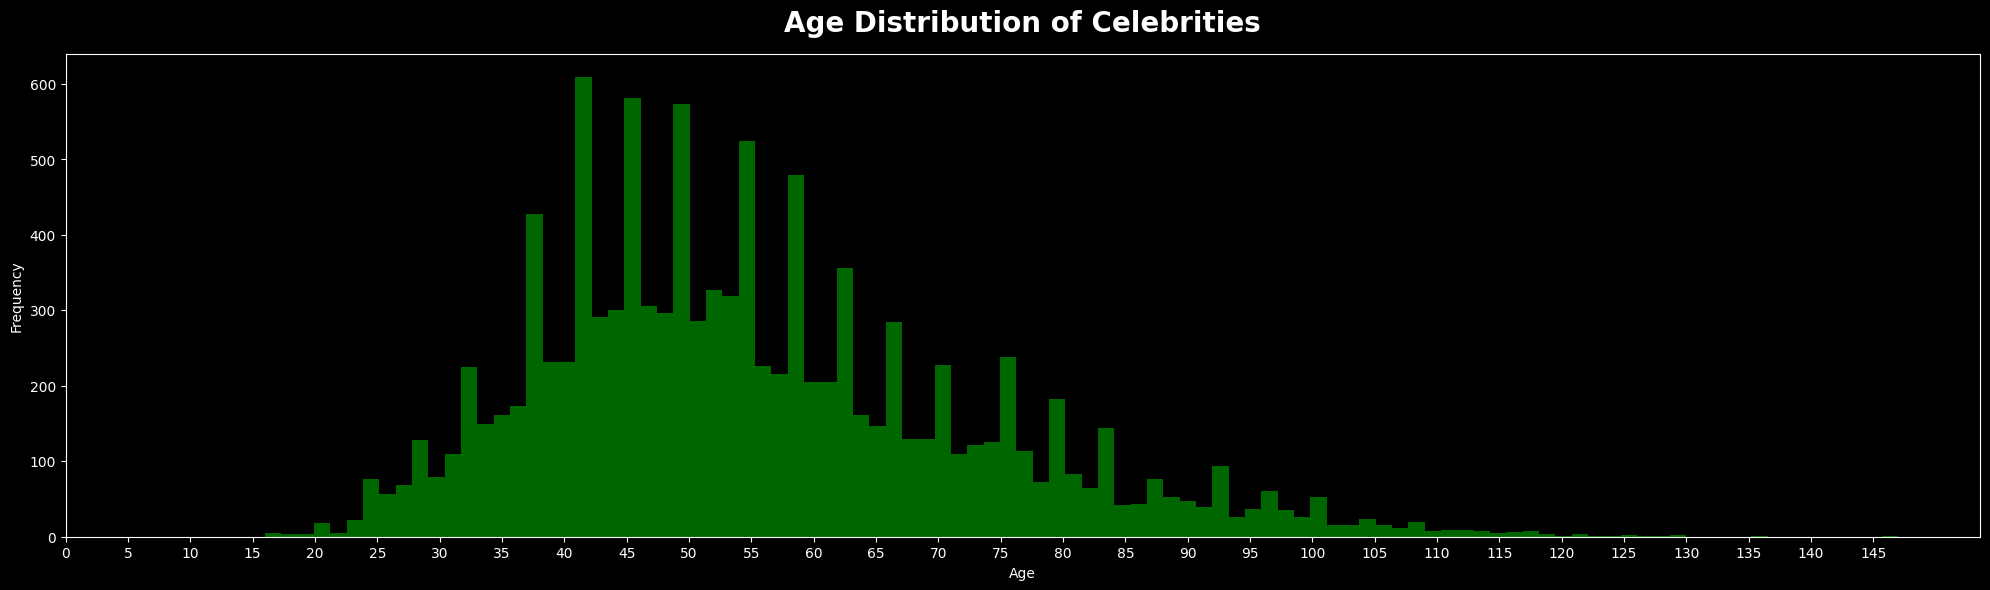

In [50]:
# Plotting the distribution of the age of the celebrities
plt.figure(figsize=(20, 6))
plt.hist(data_df["Current Age"], bins=100, color="green", alpha=0.8)

max_age = data_df["Current Age"].max()  # Getting the maximum age of the celebrities

plt.xticks(range(0, max_age, 5))

plt.xlabel("Age")
plt.ylabel("Frequency")

plt.title("Age Distribution of Celebrities", fontsize=20, fontweight="bold", y=1.03)

plt.tight_layout()
plt.show()

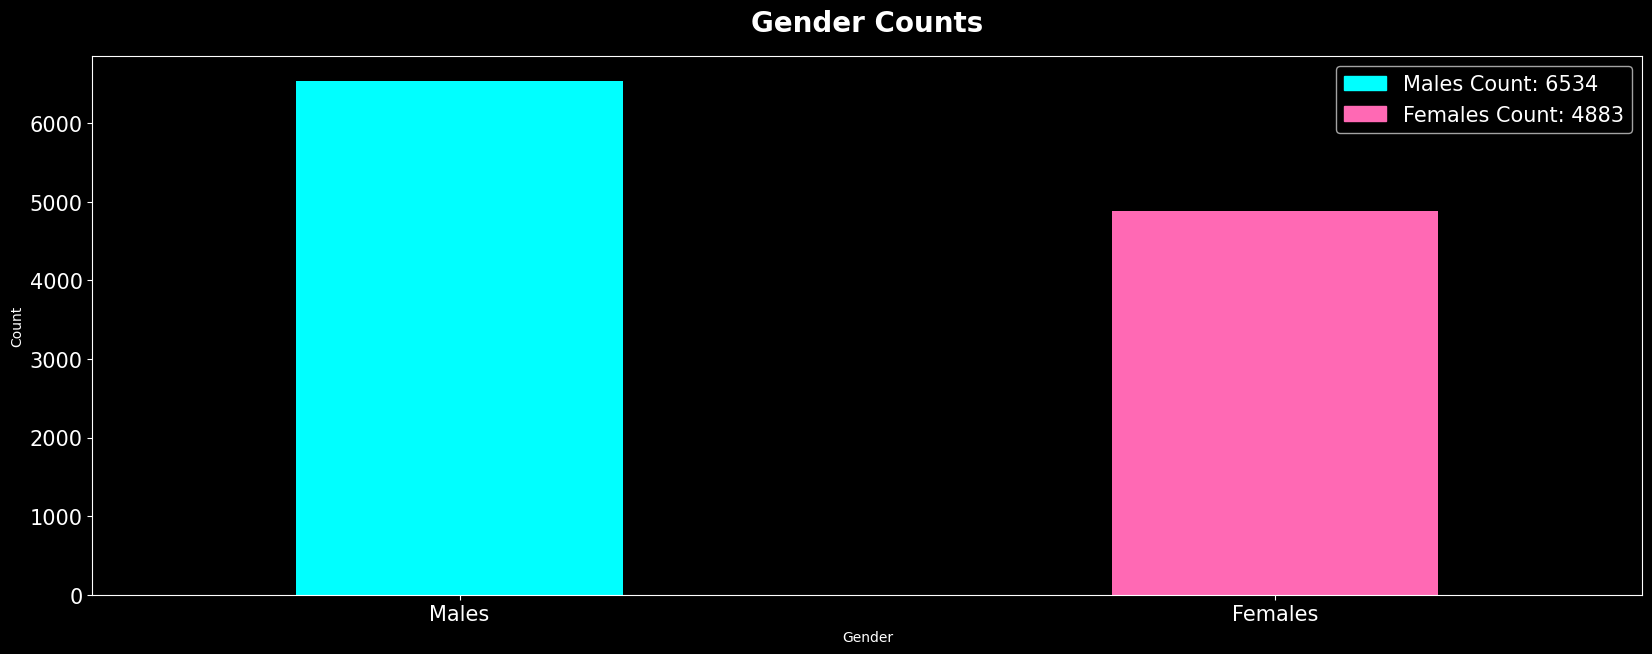

In [51]:
# Plotting the gender counts in the celebrities dataset

gender_counts = data_df[
    "Gender"
].value_counts()  # Getting the number of male and female celebrities in the dataset
gender_counts.rename(
    {0: "Females", 1: "Males"}, inplace=True
)  # Renaming 0s and 1s in the pandas series to Females and Males respectively

plt.figure(figsize=(20, 7))
gender_counts.plot(kind="bar", color=["aqua", "hotpink"], rot=0, width=0.4)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel("Gender")
plt.ylabel("Count")

plt.title("Gender Counts", fontsize=20, fontweight="bold", y=1.03)

females_patch = mpatches.Patch(
    color="hotpink", label=f"Females Count: {gender_counts[1]}"
)
males_patch = mpatches.Patch(color="aqua", label=f"Males Count: {gender_counts[0]}")
plt.legend(handles=[males_patch, females_patch], fontsize=15)

plt.show()

### Bivariate Exploration <a id="bivis"></a>


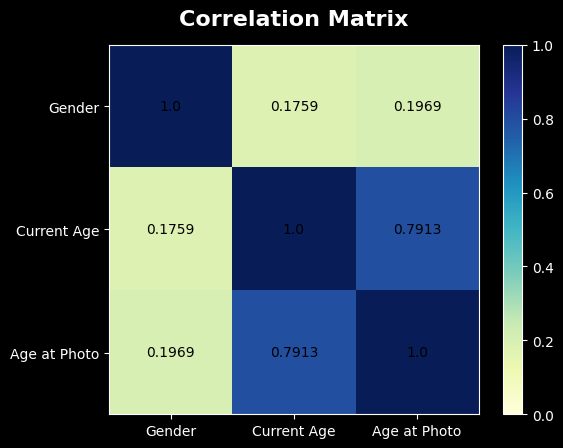

In [52]:
# Plotting the correlation matrix of the data using a heatmap

corr = data_df[
    ["Gender", "Current Age", "Age at Photo"]
].corr()  # Getting the correlation matrix of the data

plt.imshow(corr, cmap="YlGnBu", interpolation="nearest", vmin=0, vmax=1)
plt.colorbar()

for i in range(3):
    for j in range(3):
        plt.annotate(
            str(round(corr.values[i][j], 4)),
            xy=(j, i),
            ha="center",
            va="center",
            color="black",
        )

plt.title("Correlation Matrix", fontsize=16, fontweight="bold", y=1.03)

plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.show()

## Preprocessing Data <a id='pre'></a>


### Getting Images Pixels <a id='pix'></a>


In [56]:
i = 0  # Index of the image to be displayed


def load_imgs(path):
    """
    Load the image pixels from the dataset.

    Parameters:
    -   path (str): The path to the image file.

    Returns:
    -   ndarray: The image pixels as a NumPy array.
    """

    # Printing the image number being loaded
    global i
    print("Loading img no. :", i, end="\r")
    i += 1

    return cv2.imread(dataset_path + "/imdb_crop/imdb_crop/" + path)

In [57]:
# Loading the image pixels from the path
data_df["Image Pixels"] = data_df["Full Img Path"].apply(load_imgs)

In [58]:
# Dropping the Full Img Path column
data_df.drop("Full Img Path", axis=1, inplace=True)

In [59]:
# Getting the number of features in the data after replacing the image path with the image pixels
features_len = len(data_df.columns)
print(
    "Total no. of features after replacing the image path with the image pixels:",
    features_len,
)

Total no. of features after replacing the image path with the image pixels: 5


In [60]:
# Displaying 5 random rows of the data
data_df.sample(5)

Celebrity Name  Gender  Current Age  Age at Photo  \
6336       Valérie Donzelli       0           50            41   
3171           Dave Coulier       1           64            27   
5802        Thure Lindhardt       1           48            34   
10355  Elisabetta Rocchetti       0           53            34   
10469       Bronson Pinchot       1           64            39   

                                            Image Pixels  
6336   [[[250, 240, 233], [250, 240, 233], [250, 240,...  
3171   [[[154, 63, 119], [153, 62, 118], [153, 62, 11...  
5802   [[[99, 102, 106], [99, 102, 106], [99, 102, 10...  
10355  [[[13, 146, 183], [13, 146, 183], [13, 146, 18...  
10469  [[[27, 45, 44], [27, 45, 44], [27, 45, 44], [2...

In [61]:
# Describing the data
data_df.describe()

Gender   Current Age  Age at Photo
count  11417.000000  11417.000000  11417.000000
mean       0.572304     55.431462     35.960760
std        0.494766     17.635040     14.467294
min        0.000000     16.000000      0.000000
25%        0.000000     43.000000     26.000000
50%        1.000000     52.000000     34.000000
75%        1.000000     65.000000     44.000000
max        1.000000    147.000000    133.000000

In [62]:
# Displaying the datatype of the image pixels column
print("Datatype of the image pixels column:", type(data_df["Image Pixels"][0]))

Datatype of the image pixels column: <class 'numpy.ndarray'>


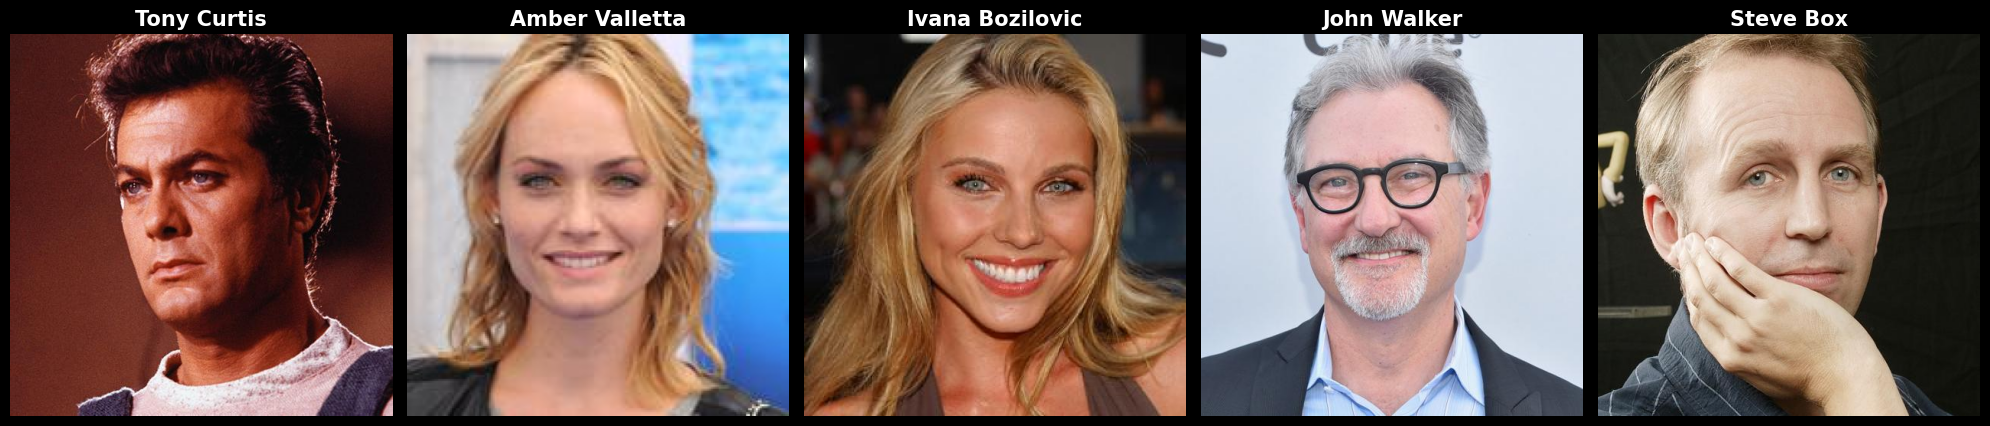

In [63]:
# Displaying 5 random images of celebrities
plt.figure(figsize=(20, 6))

for i in range(5):
    random_index = np.random.randint(0, len(data_df))  # Selecting a random index

    img_pixels = data_df["Image Pixels"][random_index]
    img_pixels = cv2.cvtColor(img_pixels, cv2.COLOR_BGR2RGB)  # Apply color conversion

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pixels)
    plt.title(data_df["Celebrity Name"][random_index], fontsize=15, fontweight="bold")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Normalizing the Images <a id='norm'></a>


In [64]:
i = 0  # Index of the image to be displayed


def resize_normalize_img(img):
    """
    Resize and normalize the image pixels.

    Parameters:
    -   img (ndarray): The image pixels as a NumPy array.

    Returns:
    -   ndarray: The resized and normalized image pixels as a NumPy array.
    """

    img = cv2.resize(img, (224, 224))  # Resize the image to 224x224 pixels

    # Convert image to numpy array of shape (224, 224, 3)
    img_pixels = image.img_to_array(img)
    img_pixels = np.expand_dims(img_pixels, axis=0)

    # Normalize the image pixels to the range of [-1, +1]
    img_pixels /= 127.5
    img_pixels -= 1

    # Printing the image number being loaded
    global i
    print("Normalizing img no. :", i, end="\r")
    i += 1
    
    return img_pixels

In [65]:
# Resizing and normalizing the image pixels
data_df["Normalized Image Pixels"] = data_df["Image Pixels"].apply(resize_normalize_img)

In [66]:
# Getting the number of features in the data after resizing and normalizing the image pixels
features_len = len(data_df.columns)
print(
    "Total no. of features after resizing and normalizing the image pixels:",
    features_len,
)

Total no. of features after resizing and normalizing the image pixels: 6


In [67]:
# Displaying 5 random rows of the data
data_df.sample(5)

Celebrity Name  Gender  Current Age  Age at Photo  \
2583  Marco Leonardi       1           52            16   
4213        Jung Suh       0           51            32   
742   Joshua Marston       1           55            35   
6859     Bar Refaeli       0           38            25   
1469  Jennifer Beals       0           59            38   

                                           Image Pixels  \
2583  [[[28, 27, 23], [29, 28, 24], [29, 28, 24], [2...   
4213  [[[100, 92, 179], [106, 98, 185], [99, 91, 178...   
742   [[[94, 119, 121], [94, 119, 121], [94, 119, 12...   
6859  [[[25, 12, 10], [25, 12, 10], [25, 12, 10], [2...   
1469  [[[1, 10, 30], [0, 13, 25], [0, 20, 12], [0, 2...   

                                Normalized Image Pixels  
2583  [[[[-0.78039217 -0.78039217 -0.8117647 ], [-0....  
4213  [[[[-0.21568626 -0.27843136  0.4039216 ], [-0....  
742   [[[[-0.26274508 -0.06666666 -0.05098039], [-0....  
6859  [[[[-0.8039216  -0.90588236 -0.92156863], [-0....  
1469  [[[[-0.9843137 -0.9137255 -0.7647059], [-0.992...

In [68]:
# Describing the data
data_df.describe()

Gender   Current Age  Age at Photo
count  11417.000000  11417.000000  11417.000000
mean       0.572304     55.431462     35.960760
std        0.494766     17.635040     14.467294
min        0.000000     16.000000      0.000000
25%        0.000000     43.000000     26.000000
50%        1.000000     52.000000     34.000000
75%        1.000000     65.000000     44.000000
max        1.000000    147.000000    133.000000

In [69]:
# Displaying the datatype of the normalized image pixels column
print(
    "Datatype of the normalized image pixels column:",
    type(data_df["Normalized Image Pixels"][0]),
)

Datatype of the normalized image pixels column: <class 'numpy.ndarray'>


In [70]:
# Showing the dimensions of the image pixels
print("Dimensions of the image pixels:", data_df["Normalized Image Pixels"][2].shape)

Dimensions of the image pixels: (1, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


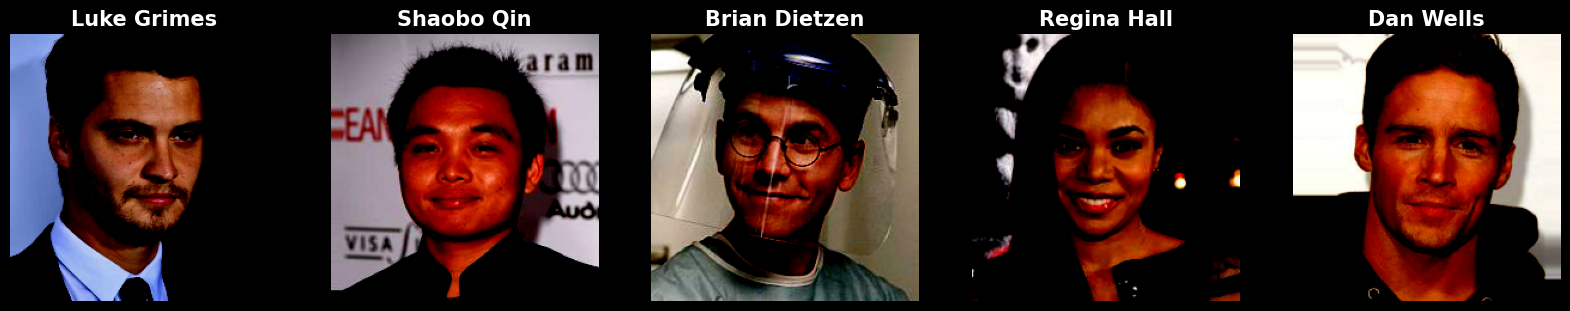

In [72]:
# Displaying 5 random normalized images of celebrities
plt.figure(figsize=(20, 6))
for i in range(5):
    random_index = np.random.randint(0, len(data_df))  # Selecting a random index
    img_pixels = data_df["Normalized Image Pixels"][random_index]
    img_pixels = img_pixels[0]  # Removing the extra dimension
    img_pixels = cv2.cvtColor(img_pixels, cv2.COLOR_BGR2RGB)  # Apply color conversion
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pixels)
    plt.title(data_df["Celebrity Name"][random_index], fontsize=15, fontweight="bold")
    plt.axis("off")

## Neural Network Construction<a id='cnn'></a>


### Building the Network (Vgg Face Descriptor Model)<a id='bld'></a>

In [73]:
# Initializing the vgg face descriptor model for face recognition
model = Sequential()

# Adding the first chunk of layers to the model as per the vgg face descriptor model architecture
# (64 filters per convolutional layer (2))
# Before every convolutional layer in chunks 1 to 5, a zero padding layer is added to preserve more spatial information
# At the end of chunks 1 to 5, a max pooling layer is added to reduce the spatial dimensions of the image

# Adding the first zero padding to the input image pixels making them 226 x 226 to preserve more spatial information
model.add(ZeroPadding2D((1, 1), input_shape=(224, 224, 3)))
# Adding the first convolutional layer with 64 filters of size 3 x 3 and relu activation function
model.add(Convolution2D(64, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, (3, 3), activation="relu"))
model.add(
    MaxPooling2D((2, 2), strides=(2, 2))
)  # Adding the first max pooling layer with a pool size of 2 x 2 and stride of 2 x 2 to reduce
# the spatial dimensions of the image

# Adding the second chunk of layers to the model as per the vgg face descriptor model architecture
# (128 filters per convolutional layer (2))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Adding the third chunk of layers to the model as per the vgg face descriptor model architecture
# (256 filters per convolutional layer (3))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Adding the fourth chunk of layers to the model as per the vgg face descriptor model architecture
# (512 filters per convolutional layer (3))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Adding the fifth chunk of layers to the model as per the vgg face descriptor model architecture
# (512 filters per convolutional layer (3))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Adding the sixth chunk of layers to the model as per the vgg face descriptor model architecture
# (4096 neurons per dense layer (2))

model.add(
    Convolution2D(4096, (7, 7), activation="relu")
)  # Adding the first 'dense' layer with 4096 neurons and relu activation function this is
# considered a dense layer because it has a kernel size of 7 x 7 which is the same as the spatial dimensions of the image
model.add(
    Dropout(0.5)
)  # Adding a dropout layer with a dropout rate of 50% to prevent overfitting
model.add(Convolution2D(4096, (1, 1), activation="relu"))
model.add(Dropout(0.5))

# Adding the seventh chunk of layers to the model as per the vgg face descriptor model architecture
# (2622 neurons per dense layer (1))

model.add(Convolution2D(2622, (1, 1)))
model.add(
    Flatten()
)  # Adding a flatten layer to flatten the output of the previous layer to a 1D vector

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

### Importing Weights<a id='wghts'></a>

In [77]:
# Check if the user wants to download the weights of the model
download_weights = False

In [78]:
# Downloading the imdb_crop dataset from the link into the current/Data directory
if download_weights == False:
    print("Vgg face descriptor Model weights not downloaded. Please download the weights, if you already have the weights ignore this message.")
else:
    !wget -P "{dataset_path}" https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5

Vgg face descriptor Model weights not downloaded. Please download the weights, if you already have the weights ignore this message.


In [79]:
# Load Vgg Face Model Weights
model.load_weights("Model/vgg_face_weights.h5")

### Predicting Face Vector Representaion<a id='vct'></a>

In [84]:
def get_vector_face(norm_img_pixels):
    """
    Get the face vector representation of the normalized image pixels.

    Parameters:
    -   norm_img_pixels (ndarray): The normalized image pixels as a NumPy array.

    Returns:
    -   face_vector (ndarray): The face vector representation of the image pixels.
    """
    
    face_vector = model.predict(norm_img_pixels, verbose=1)[0, :]

    return face_vector

In [85]:
# Getting the face vector representation of the normalized image pixels
tic = time.time()
data_df["Face Vector"] = data_df["Normalized Image Pixels"].apply(get_vector_face)
toc = time.time()

face_vector_time = str(timedelta(seconds=round(toc - tic, 2)))
print("\nTime taken to get face vectors:", face_vector_time[:-3])

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 14ms/step

Time taken to get face vectors: 0:15:46.980


In [ ]:
# Displaying 5 random rows of the data
data_df.sample(5)

Celebrity Name  Gender  Current Age  Age at Photo   
2912    Chris O'Donnell       1           53            33  \
828     Christine Woods       0           40            25   
8413    Crystal Bernard       0           62            41   
1615  George S. Clinton       1           76            56   
3141   Grant Rosenmeyer       1           32            11   

                                           Image Pixels   
2912  [[[0, 2, 3], [0, 2, 3], [0, 2, 3], [0, 2, 3], ...  \
828   [[[152, 147, 148], [152, 147, 148], [152, 147,...   
8413  [[[45, 36, 23], [44, 34, 24], [46, 32, 26], [4...   
1615  [[[56, 109, 166], [116, 168, 228], [113, 162, ...   
3141  [[[197, 176, 161], [193, 172, 157], [192, 167,...   

                                Normalized Image Pixels   
2912  [[[[-1.        -0.9843137 -0.9764706], [-1.   ...  \
828   [[[[0.19215691 0.15294123 0.16078436], [0.1921...   
8413  [[[[-0.64705884 -0.7176471  -0.81960785], [-0....   
1615  [[[[-0.56078434 -0.14509803  0.30196083], [-0....   
3141  [[[[0.54509807 0.3803922  0.26274514], [0.5215...   

                                            Face Vector  
2912  [0.03202045, -0.023105966, -0.00078073307, 0.0...  
828   [0.019072298, 0.012707691, 0.01309976, 0.00132...  
8413  [-0.013833876, -0.030935613, -0.018128648, 0.0...  
1615  [0.017354261, 0.011931814, -0.010260108, 0.024...  
3141  [0.024567952, -0.0049254405, 0.008910515, 0.00...

In [ ]:
# Describing the data
data_df.describe()

## Loading & Cleaning Test Images


### Creating a Dataframe for Testing Images

In [140]:
# Getting the test images paths
test_imgs_paths = glob.glob(dataset_path + "/test_images/*.*")
print("Total no. of test images:", len(test_imgs_paths))

Total no. of test images: 20


In [160]:
# Replacing the backslash with forward slash in the test images paths
test_imgs_paths = [path.replace("\\", "/") for path in test_imgs_paths]
print("Test images paths:\n", test_imgs_paths)

Test images paths:
 ['Images/Test Images/Abdelrahman Saaed_20_1_1.jpg', 'Images/Test Images/Abdelrahman Saaed_20_1_2.jpg', 'Images/Test Images/Abdelrahman Saaed_20_1_3.jpg', 'Images/Test Images/Abdulrahman Khaled_20_1_1.jpg', 'Images/Test Images/Begad Tamim_20_1_1.jpg', 'Images/Test Images/Belal Sameh_19_1_1.jpg', 'Images/Test Images/Fouad Ouda_20_1_1.jpg', 'Images/Test Images/Fouad Ouda_20_1_2.jpg', 'Images/Test Images/Fouad Ouda_20_1_3.jpg', 'Images/Test Images/Hazem Metwalli_20_1_1.jpg', 'Images/Test Images/Mohamed Abdelraheem_19_1_1.jpg', 'Images/Test Images/Mohamed Refaat_19_1_1.jpg', 'Images/Test Images/Mohamed Refaat_19_1_2.jpg', 'Images/Test Images/Mohamed Youssef_19_1_1.jpg', 'Images/Test Images/Mohamed Youssef_19_1_2.jpg', 'Images/Test Images/Mohamed Youssef_19_1_3.jpg', 'Images/Test Images/Mohamed Youssef_19_1_4.jpg', 'Images/Test Images/Mustafa Eslam_20_1_1.jpg', 'Images/Test Images/Mustafa Eslam_20_1_2.jpg', 'Images/Test Images/Youssef Ayman_20_1_1.jpg']


In [162]:
# Extracting the name from the test image path
test_imgs_names = []
for path in test_imgs_paths:
    test_imgs_names.append(path.split("/")[-1].split(".")[0].split("_")[0])
print("Test images names:\n", test_imgs_names)

Test images names:
 ['Abdelrahman Saaed', 'Abdelrahman Saaed', 'Abdelrahman Saaed', 'Abdulrahman Khaled', 'Begad Tamim', 'Belal Sameh', 'Fouad Ouda', 'Fouad Ouda', 'Fouad Ouda', 'Hazem Metwalli', 'Mohamed Abdelraheem', 'Mohamed Refaat', 'Mohamed Refaat', 'Mohamed Youssef', 'Mohamed Youssef', 'Mohamed Youssef', 'Mohamed Youssef', 'Mustafa Eslam', 'Mustafa Eslam', 'Youssef Ayman']


In [163]:
# Extrating the age from the test image path
test_imgs_ages = []
for path in test_imgs_paths:
    test_imgs_ages.append(path.split("/")[-1].split(".")[0].split("_")[1])
print("Test images ages:\n", test_imgs_ages)

Test images ages:
 ['20', '20', '20', '20', '20', '19', '20', '20', '20', '20', '19', '19', '19', '19', '19', '19', '19', '20', '20', '20']


In [164]:
# Extracting the gender from the test image path
test_imgs_genders = []
for path in test_imgs_paths:
    test_imgs_genders.append(path.split("/")[-1].split(".")[0].split("_")[2])
print("Test images genders:\n", test_imgs_genders)

Test images genders:
 ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']


In [165]:
# Creating a dataframe to store the test images data
test_df = pd.DataFrame(
    {
        "Name": test_imgs_names,
        "Age at Photo": test_imgs_ages,
        "Img Path": test_imgs_paths,
        "Gender": test_imgs_genders,
    }
)

In [166]:
test_df.sample(5)

Name Age at Photo   
17    Mustafa Eslam           20  \
18    Mustafa Eslam           20   
8        Fouad Ouda           20   
14  Mohamed Youssef           19   
13  Mohamed Youssef           19   

                                         Img Path Gender  
17    Images/Test Images/Mustafa Eslam_20_1_1.jpg      1  
18    Images/Test Images/Mustafa Eslam_20_1_2.jpg      1  
8        Images/Test Images/Fouad Ouda_20_1_3.jpg      1  
14  Images/Test Images/Mohamed Youssef_19_1_2.jpg      1  
13  Images/Test Images/Mohamed Youssef_19_1_1.jpg      1

In [167]:
test_df.describe()

Name Age at Photo   
count                20           20  \
unique               11            2   
top     Mohamed Youssef           20   
freq                  4           12   

                                               Img Path Gender  
count                                                20     20  
unique                                               20      1  
top     Images/Test Images/Abdelrahman Saaed_20_1_1.jpg      1  
freq                                                  1     20

In [168]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          20 non-null     object
 1   Age at Photo  20 non-null     object
 2   Img Path      20 non-null     object
 3   Gender        20 non-null     object
dtypes: object(4)
memory usage: 768.0+ bytes


### Preprocessing the Testing Dataframe

#### Getting Test Images Pixels 

In [169]:
# Creating a function to load the image pixels from the dataset
def load_test_imgs(path):
    return cv2.imread(path)

In [170]:
# Getting the image pixels of the test images
test_df["Image Pixels"] = test_df["Img Path"].apply(load_test_imgs)

In [171]:
# Dropping the Img Path column
test_df.drop("Img Path", axis=1, inplace=True)

In [172]:
# Displaying 5 random rows of the data
test_df.sample(5)

Name Age at Photo Gender   
12       Mohamed Refaat           19      1  \
14      Mohamed Youssef           19      1   
10  Mohamed Abdelraheem           19      1   
19        Youssef Ayman           20      1   
1     Abdelrahman Saaed           20      1   

                                         Image Pixels  
12  [[[3, 2, 11], [3, 2, 11], [3, 2, 11], [3, 2, 1...  
14  [[[144, 169, 171], [152, 177, 179], [163, 186,...  
10  [[[3, 30, 27], [9, 34, 30], [14, 35, 32], [27,...  
19  [[[60, 48, 38], [59, 47, 37], [59, 47, 37], [6...  
1   [[[231, 232, 223], [231, 232, 223], [231, 232,...

In [173]:
# Displaying the datatype of the image pixels column
print("Datatype of the image pixels column:", type(test_df["Image Pixels"][0]))

Datatype of the image pixels column: <class 'numpy.ndarray'>


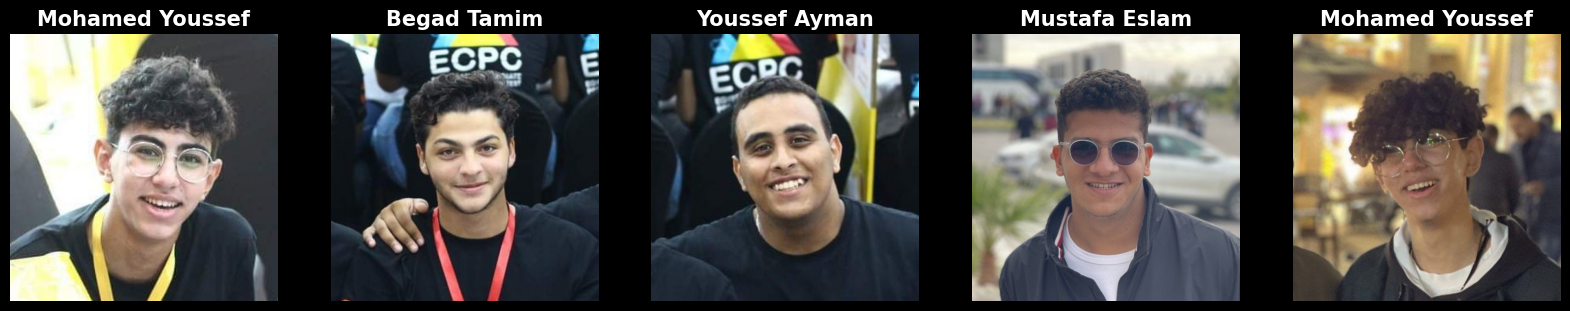

In [176]:
# Displaying 5 random test images
plt.figure(figsize=(20, 6))

# Selecting 5 unique random indices
random_indices = np.random.choice(test_df.index, size=5, replace=False)

for i, random_index in enumerate(random_indices):
    img_pixels = test_df.loc[random_index, "Image Pixels"]
    img_pixels = cv2.cvtColor(img_pixels, cv2.COLOR_BGR2RGB)  # Apply color conversion
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pixels)
    plt.title(test_df.loc[random_index, "Name"], fontsize=15, fontweight="bold")
    plt.axis("off")

#### Normalizing Testing Images

In [177]:
# Resizing and normalizing the image pixels
test_df["Normalized Image Pixels"] = test_df["Image Pixels"].apply(resize_normalize_img)

In [178]:
# Displaying 5 random rows of the data
test_df.sample(5)

Name Age at Photo Gender   
15      Mohamed Youssef           19      1  \
2     Abdelrahman Saaed           20      1   
6            Fouad Ouda           20      1   
10  Mohamed Abdelraheem           19      1   
4           Begad Tamim           20      1   

                                         Image Pixels   
15  [[[255, 255, 255], [255, 255, 255], [255, 255,...  \
2   [[[3, 2, 11], [3, 2, 11], [3, 2, 11], [3, 2, 1...   
6   [[[93, 117, 129], [90, 114, 126], [86, 110, 12...   
10  [[[3, 30, 27], [9, 34, 30], [14, 35, 32], [27,...   
4   [[[254, 254, 238], [255, 255, 239], [255, 255,...   

                              Normalized Image Pixels  
15  [[[[1. 1. 1.], [1. 1. 1.], [1. 1. 1.], [1. 1. ...  
2   [[[[-0.9764706 -0.9843137 -0.9137255], [-0.976...  
6   [[[[-0.27058822 -0.08235294  0.01176476], [-0....  
10  [[[[-0.92156863 -0.70980394 -0.73333335], [-0....  
4   [[[[0.99215686 0.9843137  0.85882354], [1.    ...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


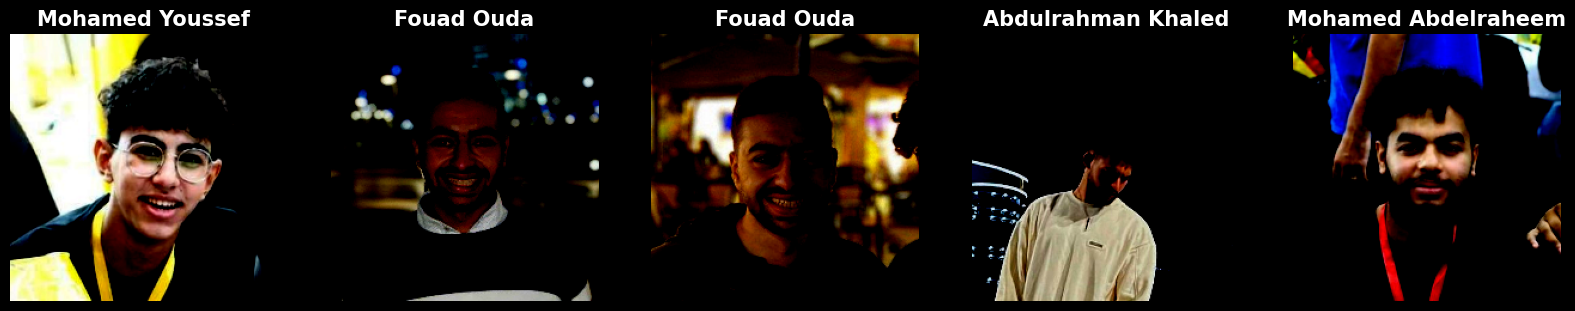

In [182]:
# Displaying 5 random normalized test images
plt.figure(figsize=(20, 6))

# Selecting 5 unique random indices
random_indices = np.random.choice(test_df.index, size=5, replace=False)

for i, random_index in enumerate(random_indices):
    img_pixels = test_df["Normalized Image Pixels"][random_index]
    img_pixels = img_pixels[0]  # Removing the extra dimension
    img_pixels = cv2.cvtColor(img_pixels, cv2.COLOR_BGR2RGB)  # Apply color conversion
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pixels)
    plt.title(test_df["Name"][random_index], fontsize=15, fontweight="bold")
    plt.axis("off")

In [183]:
# Showing the dimensions of the image pixels
print("Dimensions of the image pixels:", test_df["Normalized Image Pixels"][2].shape)

Dimensions of the image pixels: (1, 224, 224, 3)


## Prediciting (Using) The Model

### Predicting Face Vector Representaion for the Test Images

In [185]:
# Getting the face vector representation of the normalized test image pixels
tic = time.time()
test_df["Face Vector"] = test_df["Normalized Image Pixels"].apply(get_vector_face)
toc = time.time()
face_vector_time = str(timedelta(seconds=round(toc - tic, 2)))
print("Time taken to get face vectors:", face_vector_time)

1/1 [==============================] - 0s 25ms/step
Time taken to get face vectors: 0:00:02.430000


In [186]:
# Displaying 5 random rows of the data
test_df.sample(5)

Name Age at Photo Gender   
12       Mohamed Refaat           19      1  \
11       Mohamed Refaat           19      1   
10  Mohamed Abdelraheem           19      1   
4           Begad Tamim           20      1   
8            Fouad Ouda           20      1   

                                         Image Pixels   
12  [[[3, 2, 11], [3, 2, 11], [3, 2, 11], [3, 2, 1...  \
11  [[[53, 29, 23], [53, 29, 23], [53, 29, 23], [5...   
10  [[[3, 30, 27], [9, 34, 30], [14, 35, 32], [27,...   
4   [[[254, 254, 238], [255, 255, 239], [255, 255,...   
8   [[[21, 12, 9], [23, 14, 11], [25, 16, 13], [18...   

                              Normalized Image Pixels   
12  [[[[-0.9764706 -0.9843137 -0.9137255], [-0.976...  \
11  [[[[-0.58431375 -0.77254903 -0.81960785], [-0....   
10  [[[[-0.92156863 -0.70980394 -0.73333335], [-0....   
4   [[[[0.99215686 0.9843137  0.85882354], [1.    ...   
8   [[[[-0.85882354 -0.92941177 -0.9529412 ], [-0....   

                                          Face Vector  
12  [0.010639378, 0.007020085, 0.026654368, -0.001...  
11  [-0.0023476654, 0.010318967, 0.047239155, 0.00...  
10  [0.025801407, 0.017760495, 0.033367723, 0.0115...  
4   [0.008615254, 0.012883699, 0.031964447, 0.0036...  
8   [0.006635495, 0.0035123806, 0.020406006, 0.009...

### Finding Similarities Between the Celebrities Image's and Test Image's Face Representations 

In [188]:
# Creating a function to calculate the cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [202]:
# Creating a function to get the top 3 most similar celebrities to the test image
def get_top_3_similar_celebs(test_img_vector):
    # Creating a dataframe to store the cosine similarity between the test image and the celebrities
    similarity_df = pd.DataFrame(columns=["Name", "Similarity"])

    # Calculating the cosine similarity between the test image and the celebrities
    for i in range(len(data_df)):
        similarity_df.loc[i, "Name"] = data_df.loc[i, "Celebrity Name"]
        similarity_df.loc[i, "Similarity"] = cosine_similarity(
            test_img_vector, data_df.loc[i, "Face Vector"]
        )

    # Sorting the dataframe by the similarity column in descending order
    similarity_df.sort_values(by="Similarity", ascending=False, inplace=True)

    # Getting the top 3 most similar celebrities to the test image
    top_3_similar_celebs = similarity_df.iloc[:3, :]

    return top_3_similar_celebs

In [203]:
# Getting the top 3 most similar celebrities to the test image
tic = time.time()
test_df["Top 3 Similar Celebs"] = test_df["Face Vector"].apply(get_top_3_similar_celebs)
toc = time.time()
similarity_time = str(timedelta(seconds=round(toc - tic, 2)))
print(
    "Time taken to get top 3 similar celebrities for each testing image:",
    similarity_time,
)

Time taken to get top 3 similar celebrities for each testing image: 0:03:07.810000


In [204]:
# Displaying 5 random rows of the data
test_df.sample(5)

Name Age at Photo Gender   
17       Mustafa Eslam           20      1  \
7           Fouad Ouda           20      1   
0    Abdelrahman Saaed           20      1   
3   Abdulrahman Khaled           20      1   
12      Mohamed Refaat           19      1   

                                         Image Pixels   
17  [[[116, 119, 124], [109, 112, 117], [106, 109,...  \
7   [[[3, 3, 9], [3, 3, 9], [4, 4, 10], [4, 4, 10]...   
0   [[[29, 26, 18], [29, 26, 18], [32, 26, 19], [3...   
3   [[[12, 2, 2], [12, 2, 2], [12, 2, 2], [12, 2, ...   
12  [[[3, 2, 11], [3, 2, 11], [3, 2, 11], [3, 2, 1...   

                              Normalized Image Pixels   
17  [[[[-0.12941176 -0.10588235 -0.06666666], [-0....  \
7   [[[[-0.9764706  -0.9764706  -0.92941177], [-0....   
0   [[[[-0.77254903 -0.79607844 -0.85882354], [-0....   
3   [[[[-0.90588236 -0.9843137  -0.9843137 ], [-0....   
12  [[[[-0.9764706 -0.9843137 -0.9137255], [-0.976...   

                                          Face Vector   
17  [0.008018232, 0.008376271, 0.006674547, 0.0078...  \
7   [0.008064494, 0.0032690926, 0.03401693, 0.0042...   
0   [0.030992812, 0.02743062, 0.02063773, -9.55110...   
3   [0.0036728564, 0.014814389, 0.019153077, 0.011...   
12  [0.010639378, 0.007020085, 0.026654368, -0.001...   

                                 Top 5 Similar Celebs   
17                      Name Similarity
9900     P...  \
7                     Name Similarity
11397  Steve...   
0                    Name Similarity
10944  Robert...   
3                    Name Similarity
10092     Lee...   
12                   Name Similarity
9661     Jung...   

                                 Top 3 Similar Celebs  
17                    Name Similarity
9900   Pasca...  
7                     Name Similarity
11397  Steve...  
0                    Name Similarity
10944  Robert...  
3                    Name Similarity
10092     Lee...  
12                   Name Similarity
9661     Jung...

In [255]:
test_df.describe()

Name Age at Photo Gender   
count                20           20     20  \
unique               11            2      1   
top     Mohamed Youssef           20      1   
freq                  4           12     20   

                                             Image Pixels   
count                                                  20  \
unique                                                 20   
top     [[[29, 26, 18], [29, 26, 18], [32, 26, 19], [3...   
freq                                                    1   

                                  Normalized Image Pixels   
count                                                  20  \
unique                                                 20   
top     [[[[-0.77254903 -0.79607844 -0.85882354], [-0....   
freq                                                    1   

                                              Face Vector   
count                                                  20  \
unique                                                 20   
top     [0.030992812, 0.02743062, 0.02063773, -9.55110...   
freq                                                    1   

                                     Top 5 Similar Celebs   
count                                                  20  \
unique                                                 20   
top                      Name Similarity
10944  Robert...   
freq                                                    1   

                                     Top 3 Similar Celebs  
count                                                  20  
unique                                                 20  
top                      Name Similarity
10944  Robert...  
freq                                                    1

In [256]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Name                     20 non-null     object
 1   Age at Photo             20 non-null     object
 2   Gender                   20 non-null     object
 3   Image Pixels             20 non-null     object
 4   Normalized Image Pixels  20 non-null     object
 5   Face Vector              20 non-null     object
 6   Top 5 Similar Celebs     20 non-null     object
 7   Top 3 Similar Celebs     20 non-null     object
dtypes: object(8)
memory usage: 1.4+ KB


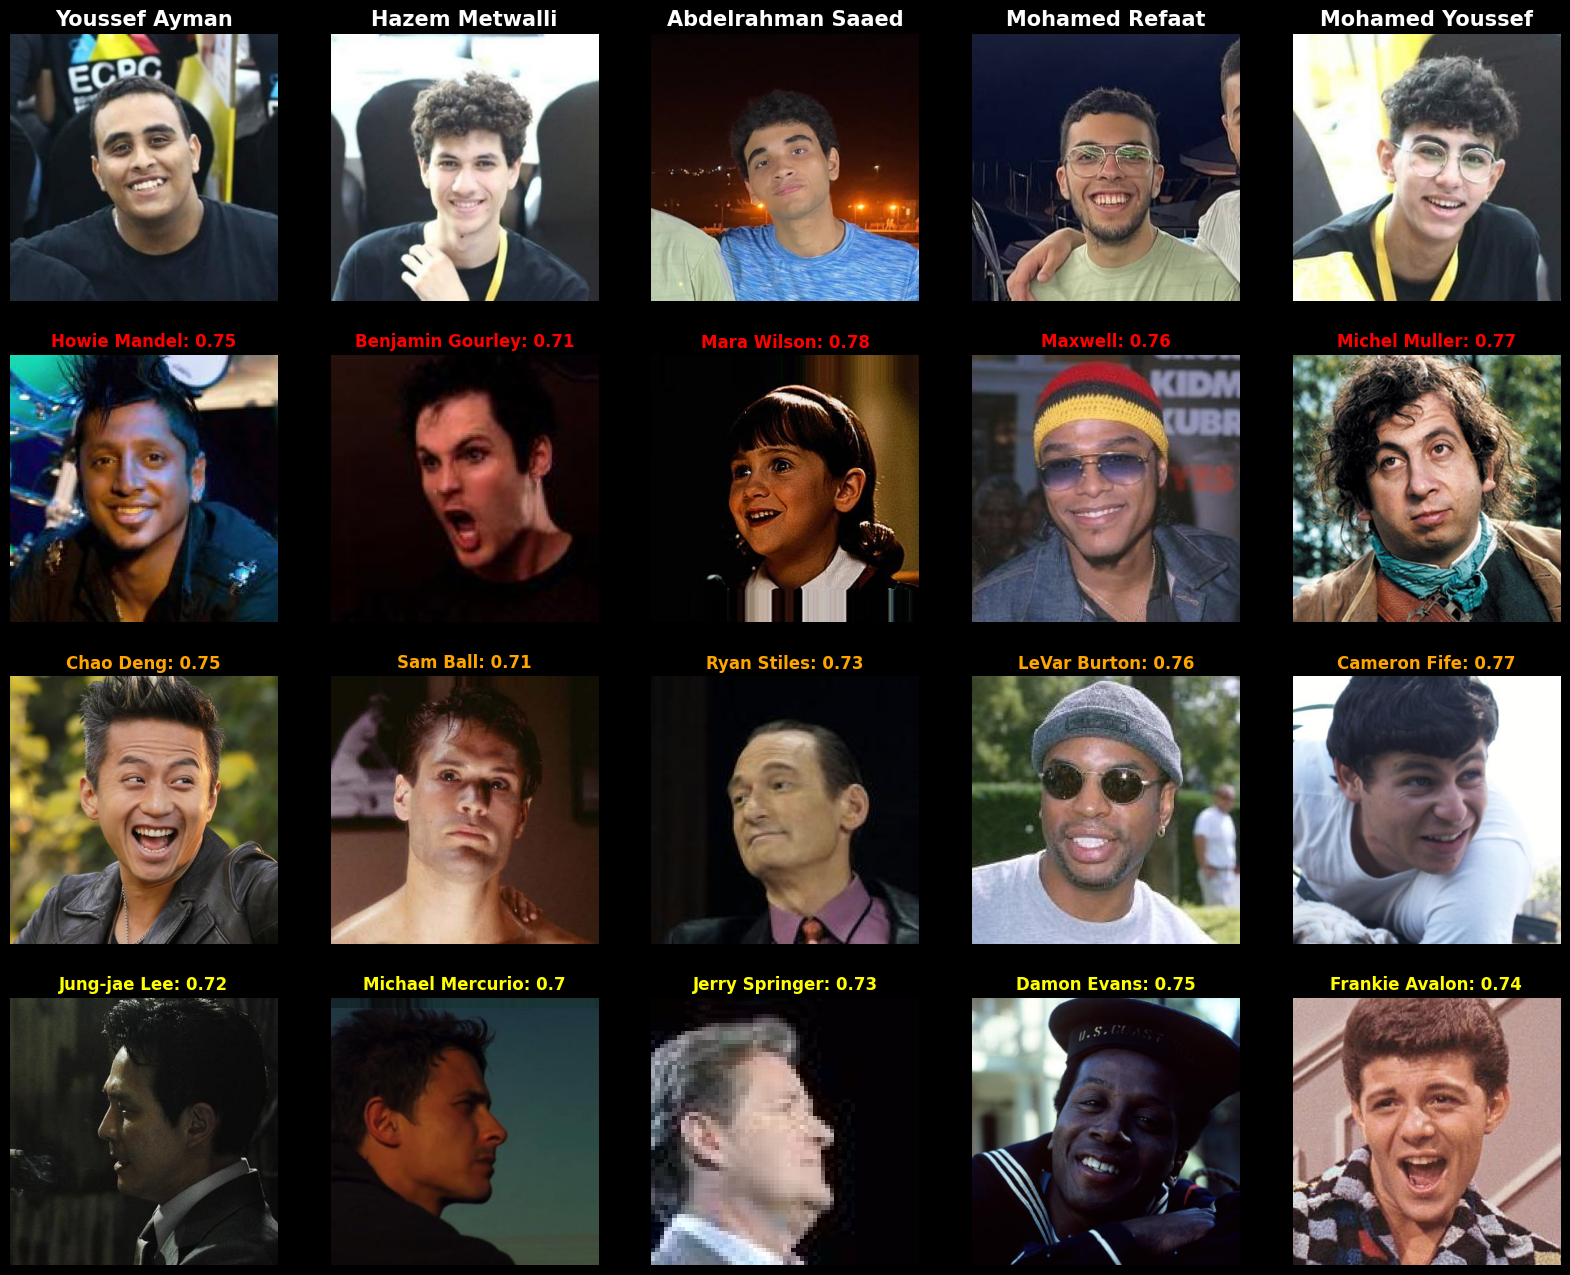

In [237]:
# Displaying the top 3 most similar celebrities to 5 test images along with their similarity score
plt.figure(figsize=(20, 16))

# Selecting 5 indices
random_indices = [19, 9, 2, 11, 15]

for i, random_index in enumerate(random_indices):
    test_img_pixels = test_df.loc[
        random_index, "Image Pixels"
    ]  # Getting the test image pixels
    test_img_pixels = cv2.cvtColor(
        test_img_pixels, cv2.COLOR_BGR2RGB
    )  # Apply color conversion

    plt.subplot(4, 5, i + 1)
    plt.imshow(test_img_pixels)
    plt.title(test_df.loc[random_index, "Name"], fontsize=15, fontweight="bold")
    plt.axis("off")

    # Creating a list of colors for the similarity scores
    colors = ["red", "orange", "yellow"]

    # Displaying the top 3 most similar celebrities to the test image
    for j in range(3):
        celeb_img_pixels = data_df[
            data_df["Celebrity Name"]
            == test_df.loc[random_index, "Top 3 Similar Celebs"].iloc[j, 0]
        ]["Image Pixels"].iloc[
            0
        ]  # Getting the celebrity image pixels

        celeb_img_pixels = cv2.cvtColor(
            celeb_img_pixels, cv2.COLOR_BGR2RGB
        )  # Apply color conversion

        plt.subplot(4, 5, 6 + i + 5 * j)
        plt.imshow(celeb_img_pixels)

        similarity_score = test_df.loc[random_index, "Top 3 Similar Celebs"].iloc[
            j, 1
        ]  # Getting the similarity score
        similarity_score = float(
            similarity_score
        )  # Converting the similarity score to float
        similarity_score = round(
            similarity_score, 2
        )  # Rounding the similarity score to 2 decimal places

        plt.title(
            f"{test_df.loc[random_index, 'Top 3 Similar Celebs'].iloc[j, 0]}: {similarity_score}",
            fontsize=12,
            fontweight="bold",
            color=colors[j],
        )

        plt.axis("off")

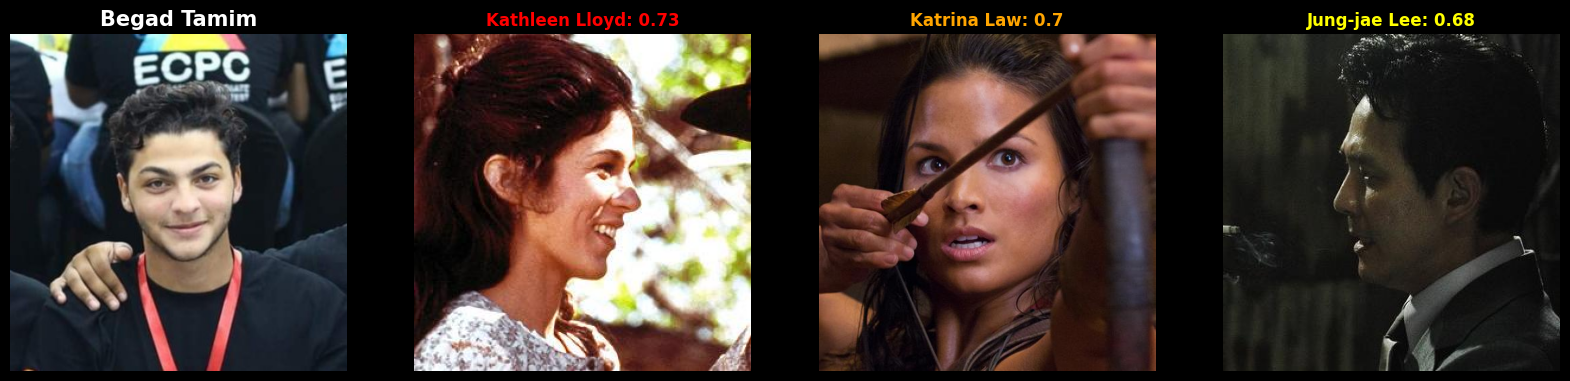

In [239]:
# Displaying the top 3 most similar celebrities to a specific test image along with their similarity score using the test image name
test_img_name = "Begad Tamim"

# Get the index of the test image
test_img_index = test_df[test_df["Name"] == test_img_name].index[0]

test_img_pixels = test_df[test_df["Name"] == test_img_name]["Image Pixels"].iloc[
    0
]  # Getting the image pixels of the test image

test_img_pixels = cv2.cvtColor(
    test_img_pixels, cv2.COLOR_BGR2RGB
)  # Apply color conversion

plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1)
plt.imshow(test_img_pixels)
plt.title(test_img_name, fontsize=15, fontweight="bold")
plt.axis("off")

# Displaying the top 3 most similar celebrities to the test image
for j in range(3):
    celeb_img_pixels = data_df[
        data_df["Celebrity Name"]
        == test_df.loc[test_img_index, "Top 3 Similar Celebs"].iloc[j, 0]
    ]["Image Pixels"].iloc[
        0
    ]  # Getting the image pixels of the celebrity

    celeb_img_pixels = cv2.cvtColor(
        celeb_img_pixels, cv2.COLOR_BGR2RGB
    )  # Apply color conversion

    plt.subplot(1, 4, j + 2)
    plt.imshow(celeb_img_pixels)

    similarity_score = test_df.loc[test_img_index, "Top 3 Similar Celebs"].iloc[
        j, 1
    ]  # Getting the similarity score
    similarity_score = float(
        similarity_score
    )  # Converting the similarity score to float
    similarity_score = round(
        similarity_score, 2
    )  # Rounding the similarity score to 2 decimal places

    plt.title(
        f"{test_df.loc[test_img_index, 'Top 3 Similar Celebs'].iloc[j, 0]}: {similarity_score}",
        fontsize=12,
        fontweight="bold",
        color=colors[j],
    )

    plt.axis("off")

In [251]:
# Get the similarity scores of the top 3 most similar celebrities to another celebrity using the celebrity name
celeb_name = "Tom Hardy"

# Get the index of the celebrity
celeb_index = data_df[data_df["Celebrity Name"] == celeb_name].index[0]

# Creating a dataframe to store the cosine similarity between the celebrity and the celebrities
similarity_df = pd.DataFrame(columns=["Name", "Similarity"])

# Calculating the cosine similarity between the celebrity and the celebrities
for i in range(len(data_df)):
    similarity_df.loc[i, "Name"] = data_df.loc[i, "Celebrity Name"]
    similarity_df.loc[i, "Similarity"] = cosine_similarity(
        data_df.loc[celeb_index, "Face Vector"], data_df.loc[i, "Face Vector"]
    )

# Sorting the dataframe by the similarity column in descending order
similarity_df.sort_values(by="Similarity", ascending=False, inplace=True)

# Getting the top 3 most similar celebrities to the celebrity
top_3_similar_celebs = similarity_df.iloc[:3, :]

In [252]:
# Displaying the top 3 most similar celebrities to the celebrity along with their similarity score
top_3_similar_celebs.head()

Name Similarity
698     Tom Hardy        1.0
7959   Ned Benson    0.73355
4107  Ross Thomas   0.720033

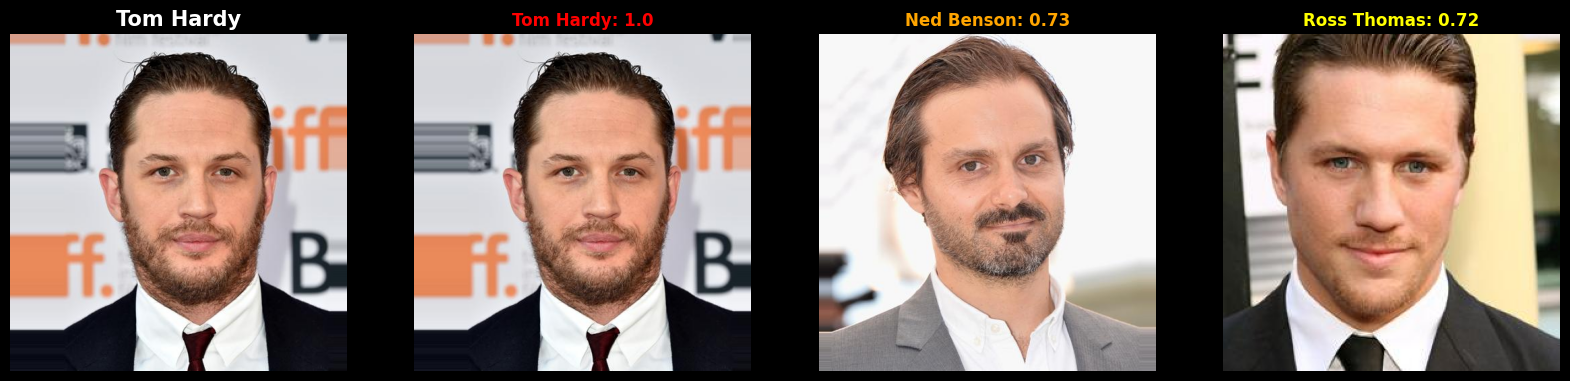

In [253]:
# Displaying the top 3 most similar celebrities to a specific celebrity along with their similarity score using the celebrity name

# Get the index of the celebrity
celeb_index = data_df[data_df["Celebrity Name"] == celeb_name].index[0]

# Get the image pixels of the celebrity
celeb_img_pixels = data_df[data_df["Celebrity Name"] == celeb_name][
    "Image Pixels"
].iloc[0]

celeb_img_pixels = cv2.cvtColor(
    celeb_img_pixels, cv2.COLOR_BGR2RGB
)  # Apply color conversion

plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1)
plt.imshow(celeb_img_pixels)
plt.title(celeb_name, fontsize=15, fontweight="bold")
plt.axis("off")

# Displaying the top 3 most similar celebrities to the celebrity
for j in range(3):
    celeb_img_pixels = data_df[
        data_df["Celebrity Name"] == top_3_similar_celebs.iloc[j, :]["Name"]
    ]["Image Pixels"].iloc[
        0
    ]  # Getting the image pixels of the celebrity

    celeb_img_pixels = cv2.cvtColor(
        celeb_img_pixels, cv2.COLOR_BGR2RGB
    )  # Apply color conversion

    plt.subplot(1, 4, j + 2)
    plt.imshow(celeb_img_pixels)

    similarity_score = top_3_similar_celebs.iloc[j, :][
        "Similarity"
    ]  # Getting the similarity score
    similarity_score = float(
        similarity_score
    )  # Converting the similarity score to float
    similarity_score = round(
        similarity_score, 2
    )  # Rounding the similarity score to 2 decimal places

    plt.title(
        f"{top_3_similar_celebs.iloc[j, :]['Name']}: {similarity_score}",
        fontsize=12,
        fontweight="bold",
        color=colors[j],
    )

    plt.axis("off")